In [ ]:
#!gdown --id 1cRcp1KDGc2gVc6aJbgoxzHx6Y1qEEOsZ

# Le modèle Séquence à Séquence

Un seq2seq,  est un modèle composé de deux RNN distincts appelés **encodeur** et **décodeur**. L'encodeur lit une séquence d'entrée un élément à la fois et produit un vecteur à chaque étape. La sortie finale de l'encodeur est conservée en tant que vecteur **contexte**. Le décodeur utilise ce vecteur de contexte pour produire une séquence de sorties, étape par étape.

![](https://i.imgur.com/tVtHhNp.png)



## Le mécanisme de l'attention

Le vecteur de longueur fixe a la charge d'encoder la totalité du "sens" de la séquence d'entrée, quelle que soit sa longueur. Compte tenu de la diversité des langues, il s'agit d'un problème très difficile à résoudre. Imaginez deux phrases presque identiques, de vingt mots, dont un seul mot diffère. Les codeurs et les décodeurs doivent être suffisamment nuancés pour représenter ce changement comme un point très légèrement différent dans l'espace.

Le **mécanisme d'attention** [introduit par Bahdanau et al.] (https://arxiv.org/abs/1409.0473) résout ce problème en donnant au décodeur un moyen de "prêter attention" à certaines parties de l'entrée, plutôt que de s'appuyer sur un seul vecteur. Pour chaque étape, le décodeur peut sélectionner une partie différente de la phrase d'entrée à prendre en compte.

![](https://i.imgur.com/5y6SCvU.png)

L'attention est calculée à l'aide d'une autre couche d'anticipation dans le décodeur. Cette couche utilise l'entrée actuelle et l'état caché pour créer un nouveau vecteur de la même taille que la séquence d'entrée (en pratique, une longueur maximale fixe). Ce vecteur est traité par softmax pour créer des *poids d'attention*, qui sont multipliés par les sorties des codeurs pour créer un nouveau vecteur de contexte, qui est ensuite utilisé pour prédire la sortie suivante.

![](https://i.imgur.com/K1qMPxs.png)

In [29]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [ ]:
cuda=True

# Chargement des fichiers de données

Les données pour ce projet sont un ensemble de plusieurs milliers de paires de traductions anglais-français.

[Cette question sur Open Data Stack Exchange] (http://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages) m'a orienté vers le site de traduction libre http://tatoeba.org/ qui propose des téléchargements à http://tatoeba.org/eng/downloads - et mieux encore, quelqu'un a fait le travail supplémentaire de diviser les paires de langues en fichiers texte individuels ici : http://www.manythings.org/anki/.

Les paires anglais-français sont trop volumineuses pour être incluses dans le repo, alors téléchargez `fra-eng.zip`, extrayez le fichier texte qu'il contient, et renommez-le en `data/eng-fra.txt` avant de continuer (pour une raison quelconque, le fichier zip est nommé à l'envers). Le fichier est une liste de paires de traductions séparées par des tabulations :

```
I am cold.    J'ai froid.
```

À l'instar du codage des caractères utilisé dans les tutoriels RNN au niveau des caractères, nous représenterons chaque mot d'une langue sous la forme d'un vecteur à un point, ou vecteur géant de zéros à l'exception d'un seul (à l'index du mot). Par rapport aux dizaines de caractères qui peuvent exister dans une langue, il y a beaucoup plus de mots, et le vecteur d'encodage est donc beaucoup plus grand. Nous allons cependant tricher un peu et réduire les données pour n'utiliser que quelques milliers de mots par langue.

### Indexation des mots

Nous aurons besoin d'un index unique par mot pour l'utiliser plus tard comme entrée et cible des réseaux. Pour garder une trace de tout cela, nous utiliserons une classe d'aide appelée `Lang` qui a des dictionnaires `word2index`,`index2word`, ainsi qu'un compte de chaque mot `word2count` à utiliser pour remplacer plus tard les mots rares.

In [ ]:
SOS_token = 0 # Début de la phrase
EOS_token = 1 # Fin de la phrase

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2 # Initialisation avec SOS et EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            # Add new word
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            # Ajouter un mot vu en augmentant son nombre
            self.word2count[word] += 1

### Lecture et décodage des fichiers

Les fichiers sont tous en Unicode, pour simplifier nous transformerons les caractères Unicode en ASCII, nous mettrons tout en minuscules et nous supprimerons la plupart des signes de ponctuation.

In [ ]:
### Normaliser le texte
def unicode_to_ascii(s):
    # Convertir une chaîne Unicode en caractères ASCII simples
    normalized_s = [c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn']
    return ''.join(normalized_s)

def normalize_string(s):
    # Minuscules, suppression des espaces, de la ponctuation et des caractères non alphabétiques
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

Pour lire le fichier de données, nous allons diviser le fichier en lignes, puis diviser les lignes en paires. Les fichiers sont tous en anglais &rarr ; autre langue, donc si nous voulons traduire d'autre langue &rarr ; anglais, j'ai ajouté le drapeau `reverse` pour inverser les paires.

In [ ]:
### Analyse et nettoyage des données textuelles
def readLangs(lang1, lang2, reverse=False):

    print('Lecture des lignes dun fichier...')

    # Read text from file, split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split lines into pairs, normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]

    if reverse: # If we're reversing pairs
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

### Filtrage des phrases

Puisqu'il y a beaucoup de phrases d'exemple et que nous voulons former quelque chose rapidement, nous allons réduire l'ensemble des données à des phrases relativement courtes et simples. Ici, la longueur maximale est de 10 mots (ponctuation comprise) et nous filtrons les phrases qui se traduisent par "Je suis" ou "Il est", etc.

In [ ]:

MAX_LENGTH = 10 # Longueur maximale de la phrase, nombre de mots

# Filtre pour n'utiliser que des phrases commençant par  "I am", "She is", "They are", etc.
eng_prefixes = (
        'i am', 'i m',
        'she is', 'she s',
        'he is', 'he s',
        'you are', 'you re',
        'we are', 'we re',
        'they are', 'they re'
        )

def pair_filter(p):
    """
    Filtre pour les paires qui tombent dans la limite de MAX_LENGTH et qui commencent par nos préfixes
    Retourne Vrai ou Faux

    Si X à eng/reverse=True -> p[1].startswith
    Si eng à X/reverse=False -> p[0].startswith
    """
    return (len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes))

def filter_pairs(pairs):
    # Appliquer le filtre des paires
    return [pair for pair in pairs if pair_filter(pair)]

### Prepare data
def prepare_data(lang1, lang2, reverse=False):
    # Lire les paires de phrases
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print('Lire %s paires de phrases' % len(pairs))

    # Paires de filtres
    pairs = filter_pairs(pairs)
    print('Filtre jusqua %s paires de phrases' % len(pairs))

    # Compter les mots
    print('Compter les mots...')
    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print('Mots compts:')
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs



Le processus complet de préparation des données est le suivant

* Lire le fichier texte et le diviser en lignes, diviser les lignes en paires
* Normaliser le texte, filtrer par la longueur et le contenu.
* Établir des listes de mots à partir des phrases par paires

In [ ]:
# Échantillon de paires
input_lang, output_lang, pairs = prepare_data('eng', 'fra', True)
print(random.choice(pairs))

Lecture des lignes dun fichier...
Lire 135842 paires de phrases
Filtre jusqua 11893 paires de phrases
Compter les mots...
Mots compts:
fra 4920
eng 3228
['je suis veinarde .', 'i m in luck .']


## Transformer les données d'entraînement en tenseurs/variables

Pour l'entraînement, nous devons transformer les phrases en quelque chose que le réseau neuronal peut comprendre, ce qui signifie bien sûr des nombres. Chaque phrase sera divisée en mots et transformée en un tenseur, où chaque mot est remplacé par l'index (à partir des index Lang créés précédemment). Lors de la création de ces tenseurs, nous ajouterons également le jeton EOS pour signaler que la phrase est terminée.

![](https://i.imgur.com/LzocpGH.png)

Un tenseur est un tableau multidimensionnel de nombres, défini par un certain type, par exemple FloatTensor ou LongTensor. Dans ce cas, nous utiliserons LongTensor pour représenter un tableau d'index entiers.

Les modules PyTorch pouvant être entraînés prennent des variables en entrée, plutôt que de simples tenseurs. Une Variable est en fait un Tenseur capable de garder une trace de l'état du graphe, ce qui rend possible l'autograd (calcul automatique des gradients à rebours).

In [ ]:

def indices_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensor_from_sentence(lang, sentence):
    indices = indices_from_sentence(lang, sentence)
    indices.append(EOS_token)
    sentence_tensor = torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)

    return sentence_tensor

def tensors_from_pair(pair):
    input_tensor = tensor_from_sentence(input_lang, pair[0])
    target_tensor = tensor_from_sentence(output_lang, pair[1])

    return (input_tensor, target_tensor)

# Construire les modèles

## L'encodeur


L'encodeur d'un réseau seq2seq est un RNN qui produit une valeur pour chaque mot de la phrase d'entrée. Pour chaque mot d'entrée, le codeur produit un vecteur et un état caché, et utilise l'état caché pour le mot d'entrée suivant.

In [ ]:


##### SEQ2SEQ MODEL

class EncoderRNN(nn.Module):
    """
    Seq2seq encoder is an RNN.

    For each input word, the encoder outputs a vector and a hidden state, and
    uses the hidden state for the next input word.
    """
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size) #LSTM

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class DecoderRNN(nn.Module):
    """
    Decoder is another RNN that takes in the encoder output vector(s) and
    outputs a sequence of words to create the translation.

    The most basic seq2seq decoder uses only the last output of the encoder.
    This last output is sometimes caled the "context vector", as it encodes
    the context of the entire sequence. This context vector is used as the
    initial hidden state of the decoder.

    At each step of decoding, the decoder is given an input token and hidden
    state. The initial input token is the start of string (SOS) token.
    The first hidden state is the context vector (the encoder's last hidden
    state).
    """
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))

        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)






## Attention Decoder

### Interprétation du modèle de Bahdanau et al.

Le modèle d'attention de [Neural Machine Translation by Jointly Learning to Align and Translate] (https://arxiv.org/abs/1409.0473) est décrit par la série d'équations suivante.

<img src="https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/49df8404d938a6edbf729876405558cc2c2b3013//assets/seq2seq7.png" style="float: right" />


Chaque sortie du décodeur est conditionnée par les sorties précédentes et un certain $\mathbf x$, où $\mathbf x$ consiste en l'état caché actuel (qui prend en compte les sorties précédentes) et le "contexte" d'attention, qui est calculé ci-dessous. La fonction $g$ est une couche entièrement connectée avec une activation non linéaire, qui prend en entrée les valeurs $y_{i-1}$, $s_i$ et $c_i$ concaténées.

$$
p(y_i \mid \{y_1,...,y_{i-1}\},\mathbf{x}) = g(y_{i-1}, s_i, c_i)
$$

L'état caché actuel $s_i$ est calculé par un RNN $f$ avec le dernier état caché $s_{i-1}$, la dernière valeur de sortie du décodeur $y_{i-1}$ et le vecteur de contexte $c_i$.

Dans le code, le RNN sera une couche `nn.GRU`, l'état caché $s_i$ sera appelé `hidden`, la sortie $y_i$ sera appelée `output`, et le contexte $c_i$ sera appelé `context`.

$$
s_i = f(s_{i-1}, y_{i-1}, c_i)
$$

Le vecteur de contexte $c_i$ est une somme pondérée de toutes les sorties de l'encodeur, où chaque poids $a_{ij}$ représente le degré d'"attention" accordé à la sortie de l'encodeur correspondant $h_j$.

$$
c_i = \sum_{j=1}^{T_x} a_{ij} h_j
$$

... où chaque poids $a_{ij}$ est une "énergie" d'attention normalisée (sur toutes les étapes) $e_{ij}$ ...

$$
a_{ij} = \dfrac{exp(e_{ij})}{\sum_{k=1}^{T} exp(e_{ik})}
$$

... où chaque énergie d'attention est calculée avec une fonction $a$ (telle qu'une autre couche linéaire) en utilisant le dernier état caché $s_{i-1}$ et la sortie particulière du codeur $h_j$ :

$$
e_{ij} = a(s_{i-1}, h_j)
$$

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attention = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attention_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)

        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attention_weights = F.softmax(self.attention(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attention_applied = torch.bmm(attention_weights.unsqueeze(0),
                encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attention_applied[0]), 1)
        output = self.attention_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)

        return output, hidden, attention_weights

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Formation

## Définition d'une itération de formation

Pour l'apprentissage, nous faisons d'abord passer la phrase d'entrée par l'encodeur, mot par mot, et gardons une trace de chaque sortie et du dernier état caché. Ensuite, le décodeur reçoit le dernier état caché du décodeur comme premier état caché, et le jeton `<SOS>` comme première entrée. À partir de là, nous itérons pour prédire le prochain jeton du décodeur.

### Forçage de l'enseignant et échantillonnage programmé

Le "forçage de l'enseignant", ou échantillonnage du maximum de vraisemblance, consiste à utiliser les sorties cibles réelles comme entrée suivante lors de l'apprentissage. L'alternative consiste à utiliser la propre estimation du décodeur comme entrée suivante. L'utilisation du forçage par l'enseignant peut permettre au réseau de converger plus rapidement, mais [lorsque le réseau formé est exploité, il peut présenter une instabilité] (http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

On peut observer des sorties de réseaux forcés par l'enseignant qui lisent avec une grammaire cohérente mais qui s'éloignent de la traduction correcte - on peut considérer que le réseau a appris à écouter les instructions de l'enseignant, sans apprendre à s'aventurer par lui-même.

La solution au "problème" du forçage de l'enseignant est connue sous le nom de [Scheduled Sampling] (https://arxiv.org/abs/1506.03099), qui alterne simplement l'utilisation des valeurs cibles et des valeurs prédites lors de la formation. Nous choisirons aléatoirement d'utiliser le forçage de l'enseignant avec une instruction if pendant l'apprentissage - parfois nous utiliserons la cible réelle comme entrée (en ignorant la sortie du décodeur), parfois nous utiliserons la sortie du décodeur.

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Former une interaction
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Encode input
    for e_i in range(input_length):
        # Inclut l'état caché de la dernière entrée lors de l'encodage de l'entrée actuelle
        encoder_output, encoder_hidden = encoder(input_tensor[e_i], encoder_hidden)
        encoder_outputs[e_i] = encoder_output[0, 0]

    # Le décodeur utilise le jeton SOS comme première entrée
    decoder_input = torch.tensor([[SOS_token]], device=device)

    # Le décodeur utilise le dernier état caché de l'encodeur comme premier état caché
    decoder_hidden = encoder_hidden

    # Décidez au hasard d'utiliser ou non le forçage des enseignants pour le décodeur
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Forçage de l'enseignant : Nourrir la cible comme prochaine entrée
        for d_i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            loss += criterion(decoder_output, target_tensor[d_i])

            decoder_input = target_tensor[d_i] # Teacher forcing
    else:
        # Pas de forçage de l'enseignant : utilisez la prédiction du décodeur comme prochaine entrée
        for d_i in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            top_v, top_i = decoder_output.topk(1)
            decoder_input = top_i.squeeze().detach() # Détacher de l'historique en entrée

            loss += criterion(decoder_output, target_tensor[d_i])

            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


Enfin, des fonctions d'aide permettent d'imprimer le temps écoulé et le temps restant estimé, en fonction de l'heure actuelle et de la progression.

In [ ]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Formation en cours d'exécution

Une fois que tout est en place, nous pouvons initialiser un réseau et commencer l'entraînement.

Pour commencer, nous initialisons les modèles, les optimiseurs et une fonction de perte (critère).

In [ ]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size).cuda()
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).cuda()
USE_CUDA=True
# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Ensuite, définissez des variables pour le traçage et le suivi des progrès :

In [ ]:
# Configuring training
n_epochs = 50000
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

Pour l'entraînement proprement dit, nous appelons la fonction train plusieurs fois, en imprimant un résumé au fur et à mesure.

*Note:* Si vous exécutez ce cahier, vous pouvez vous entraîner, interrompre le noyau, évaluer, et continuer l'entraînement plus tard. Vous pouvez commenter les lignes ci-dessus où l'encodeur et le décodeur sont initialisés (afin qu'ils ne soient pas réinitialisés) ou simplement exécuter le cahier à partir de la cellule suivante.

In [ ]:

for epoch in range(1, n_epochs + 1):

    # Obtenir les données d'entraînement pour ce cycle
    training_pair = tensors_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Exécuter la fonction train
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Garder une trace des pertes
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

0m 53s (- 43m 52s) (1000 2%) 3.4330
1m 12s (- 29m 11s) (2000 4%) 2.9362
1m 32s (- 24m 10s) (3000 6%) 2.7802
1m 51s (- 21m 25s) (4000 8%) 2.6355
2m 11s (- 19m 43s) (5000 10%) 2.5719
2m 31s (- 18m 30s) (6000 12%) 2.4810
2m 50s (- 17m 27s) (7000 14%) 2.3616
3m 10s (- 16m 39s) (8000 16%) 2.3171
3m 29s (- 15m 56s) (9000 18%) 2.2565
3m 49s (- 15m 18s) (10000 20%) 2.1844
4m 9s (- 14m 44s) (11000 22%) 2.1463
4m 28s (- 14m 11s) (12000 24%) 2.1502
4m 48s (- 13m 41s) (13000 26%) 2.0407
5m 8s (- 13m 13s) (14000 28%) 2.0348
5m 27s (- 12m 45s) (15000 30%) 1.9386
5m 47s (- 12m 19s) (16000 32%) 1.9307
6m 7s (- 11m 53s) (17000 34%) 1.8569
6m 26s (- 11m 27s) (18000 36%) 1.7887
6m 46s (- 11m 3s) (19000 38%) 1.7769
7m 6s (- 10m 39s) (20000 40%) 1.7409
7m 25s (- 10m 15s) (21000 42%) 1.7014
7m 45s (- 9m 52s) (22000 44%) 1.7123
8m 4s (- 9m 29s) (23000 46%) 1.6701
8m 24s (- 9m 7s) (24000 48%) 1.6301
8m 44s (- 8m 44s) (25000 50%) 1.6271
9m 4s (- 8m 22s) (26000 52%) 1.5795
9m 23s (- 8m 0s) (27000 54%) 1.6403
9m

## Tracé des pertes d'entraînement

Le tracé est réalisé avec matplotlib, en utilisant le tableau `plot_losses` qui a été créé pendant l'entraînement.

<Figure size 640x480 with 0 Axes>

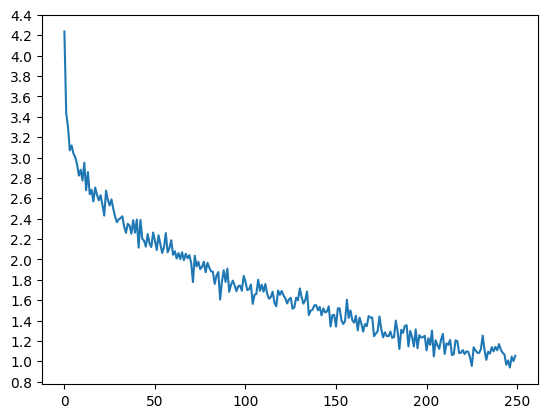

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Évaluation du réseau

L'évaluation est en grande partie la même que l'entraînement, mais il n'y a pas de cibles. Au lieu de cela, nous renvoyons toujours les prédictions du décodeur à lui-même. Chaque fois qu'il prédit un mot, nous l'ajoutons à la chaîne de sortie. S'il prédit le jeton EOS, nous nous arrêtons là. Nous stockons également les résultats de l'attention du décodeur pour chaque étape afin de les afficher ultérieurement.

In [ ]:
##### EVALUATION
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(input_lang, sentence)
        input_length = input_tensor.size()[0]

        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for e_i in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[e_i], encoder_hidden)
            encoder_outputs[e_i] += encoder_output[0, 0]

        # Start of sentence token
        decoder_input = torch.tensor([[SOS_token]], device=device)

        # Decoder's initial hidden state is encoder's last hidden state
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for d_i in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[d_i] = decoder_attention.data

            top_v, top_i = decoder_output.data.topk(1)

            if top_i.item() == EOS_token: # End of sentence
                decoded_words.append('<EOS>')
                break
            else:
                # Append prediction
                decoded_words.append(output_lang.index2word[top_i.item()])

            # Use prediction as input
            decoder_input = top_i.squeeze().detach()

        return decoded_words, decoder_attentions[:d_i + 1]

Nous pouvons évaluer des phrases aléatoires de l'ensemble de formation et imprimer l'entrée, la cible et la sortie afin d'émettre des jugements subjectifs sur la qualité :

In [ ]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)

        print('>', pair[0])
        print('=', pair[1])

        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)

        print('<', output_sentence)
        print()

In [ ]:
evaluate_randomly(encoder,decoder)

> j etudie l economie a l universite .
= i m studying economics at university .
< i m studying at at at . . <EOS>

> elles sont folles .
= they re crazy .
< they re crazy . <EOS>

> je ne suis pas au bureau aujourd hui .
= i m not in the office today .
< i m not in the today today . <EOS>

> vous etes fort elegantes .
= you re very sophisticated .
< you re very stylish . <EOS>

> il resolut le difficile probleme .
= he solved the difficult problem .
< he saw the best problem . <EOS>

> je n en ai pas termine .
= i m not finished .
< i m not done . <EOS>

> je ne suis pas laide .
= i m not ugly .
< i m not guilty . <EOS>

> nous allons faire ce que nous pouvons .
= we re going to do everything we can .
< we re going to do we can . <EOS>

> tu es tres avise .
= you re very wise .
< you re very wise . <EOS>

> il est a son cote .
= he s at her side .
< he is his his side . <EOS>



# Visualiser l'attention

Une propriété utile du mécanisme d'attention est que ses sorties sont très interprétables. Parce qu'il est utilisé pour pondérer des sorties d'encodeurs spécifiques de la séquence d'entrée, nous pouvons imaginer regarder où le réseau se concentre le plus à chaque pas de temps.

Vous pouvez simplement lancer `plt.matshow(attentions)` pour voir la sortie de l'attention affichée sous forme de matrice, les colonnes étant les pas d'entrée et les lignes les pas de sortie :

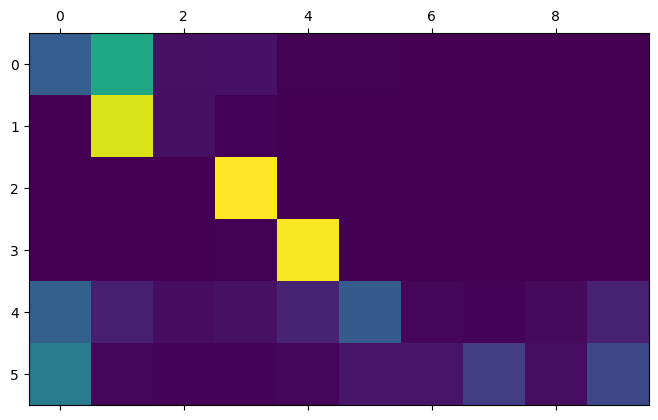

In [ ]:

output_words, attentions = evaluate(encoder,decoder, "je suis trop froid .")
plt.matshow(attentions.numpy())

Pour une meilleure expérience de visualisation, nous ferons le travail supplémentaire d'ajouter des axes et des étiquettes :

In [ ]:
def show_attention(input_sentence, output_words, attentions):
    # TODO savefig
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    print('input =', input_sentence)
    print('output = ', ' '.join(output_words))

    show_attention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output =  she s two years younger than me . <EOS>


<ipython-input-24-a93bcd577b44>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-a93bcd577b44>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


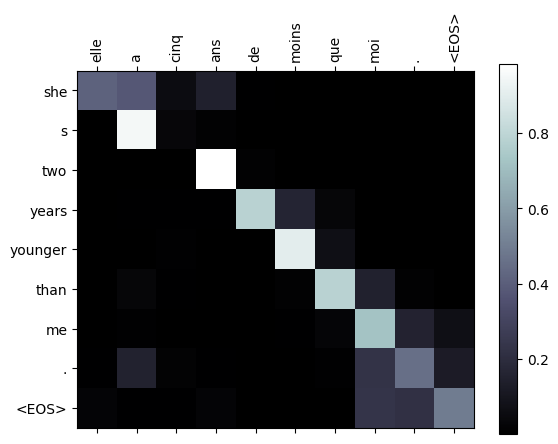

In [ ]:
# Test cases
evaluate_and_show_attention('elle a cinq ans de moins que moi .')


input = elle est trop petit .
output =  she s too loud . <EOS>


<ipython-input-24-a93bcd577b44>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-a93bcd577b44>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


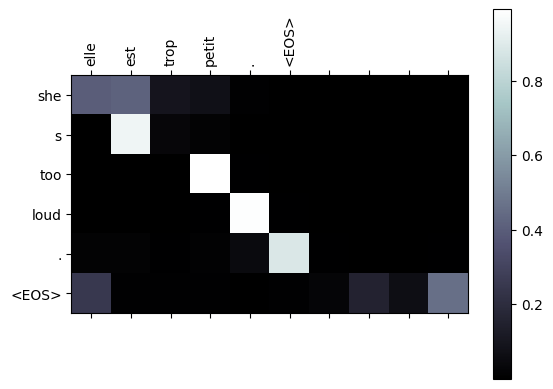

In [ ]:
evaluate_and_show_attention("elle est trop petit .")

input = je ne crains pas de mourir .
output =  i m not afraid of dying . <EOS>


<ipython-input-24-a93bcd577b44>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-a93bcd577b44>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


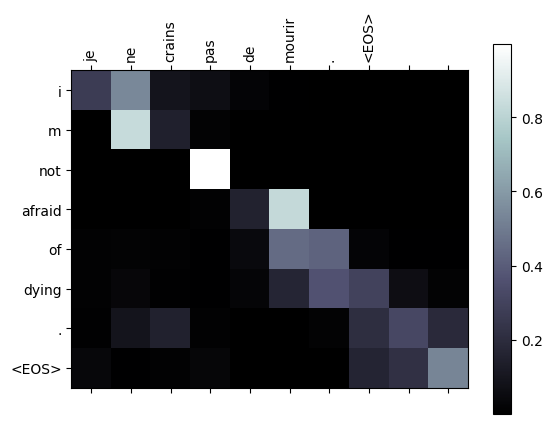

In [ ]:
evaluate_and_show_attention("je ne crains pas de mourir .")

input = c est un jeune directeur plein de talent .
output =  he is a man young man . <EOS>


<ipython-input-24-a93bcd577b44>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-24-a93bcd577b44>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


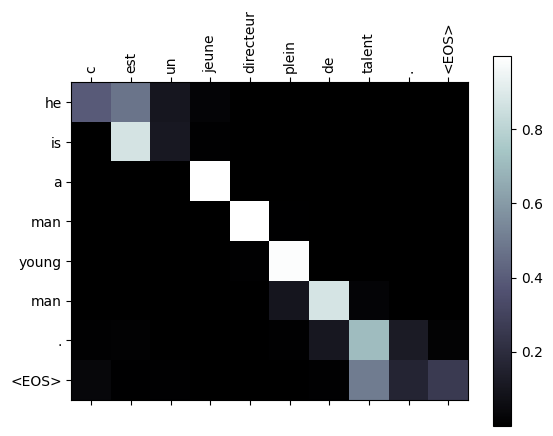

In [ ]:
evaluate_and_show_attention("c est un jeune directeur plein de talent .")

In [ ]:

#print('Saving model...')
#torch.save(encoder, 'encoder.pt')
#torch.save(attention_decoder, 'attention_decoder.pt')